In [117]:
!pip install -Uqq fastbook

In [2]:
import fastbook
fastbook.setup_book()


In [3]:
from fastbook import *

In [4]:
from fastai.vision.all import *

In [5]:
matplotlib.rc('image', cmap='Greys')

In [6]:
data = [[1,2,3], [4,5,6]]
arr = array(data)
tns = tensor(data)

In [7]:
tns[0]
arr[0]

array([1, 2, 3])

In [8]:
# select a single colum
tns[:,0]
arr[:,0]
# select 2 cols from row with index 1
tns[1, 0:2]

tensor([4, 5])

In [9]:
# add 1 to all tabl
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [10]:
tns.type()

'torch.LongTensor'

In [11]:
tns*1.2

tensor([[1.2000, 2.4000, 3.6000],
        [4.8000, 6.0000, 7.2000]])

In [12]:
# get mnist path
path = untar_data(URLs.MNIST_SAMPLE)

In [13]:
Path.BASE_PATH = path

In [14]:
path.ls()   

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [15]:
# define mean for training data
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape


torch.Size([6131, 28, 28])

In [16]:
stacked_threes[0].type()

'torch.FloatTensor'

In [17]:
# load images and pile them in stack 
threes_valid = (path/'train'/'3').ls().sorted()
sevens_valid = (path/'train'/'7').ls().sorted()
valid_3_tensors = torch.stack([
    tensor(Image.open(o)) for o in threes_valid
]).float()
# normalize so that value of is in range 0..1
valid_3_tensors = valid_3_tensors / 255


valid_7_tensors = torch.stack([
    tensor(Image.open(o)) for o in sevens_valid
]).float()
valid_7_tensors = valid_7_tensors / 255


In [18]:
valid_3_tensors.type()

'torch.FloatTensor'

<Axes: >

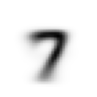

In [19]:
# # mean(0) - means, average along all images
# # basically it adds corresponding cells of the tensor
# # and divides it by count of images
show_image(valid_7_tensors.mean(0))


<Axes: >

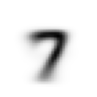

In [20]:
show_image(stacked_sevens.mean(0))

<Axes: >

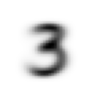

In [21]:
show_image(valid_3_tensors.mean(0))

<Axes: >

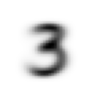

In [22]:
show_image(stacked_threes.mean(0))

In [261]:
def L1(train: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    return (train - label).abs().mean()

def L2(train: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    return ((train - label)**2).mean().sqrt()

def mnist_distance(a: torch.Tensor,b: torch.Tensor): return (a-b).abs().mean((-1, -2))

def f(x): return x**2

def mse(pred, target): return ((pred-target)**2).mean()

In [24]:
stacked_threes.mean(0).size()

torch.Size([28, 28])

In [25]:
train_3_average = stacked_threes.mean(0)
valid_3_average = valid_3_tensors.mean(0)
train_7_average = stacked_sevens.mean(0)
valid_7_average = valid_7_tensors.mean(0)

In [26]:
# print(L1(train_3_average, valid_3_average))
print(L2(train_7_average, valid_7_average))

tensor(0.)


In [27]:
print(L1(stacked_threes, valid_3_average))

tensor(0.1313)


In [28]:
print(L1(valid_3_tensors, train_3_average))

tensor(0.1313)


In [29]:
dist = mnist_distance(valid_3_tensors, train_3_average)

In [30]:
dist.size()

torch.Size([6131])

In [31]:
def is_3(x): return mnist_distance(x, train_3_average) < mnist_distance(x, train_7_average)

In [32]:
a_3 = valid_3_tensors[0]
is_3(a_3)

tensor(True)

In [33]:
a_7 = valid_7_tensors[0]
a_7.size()

torch.Size([28, 28])

In [34]:
is_3(a_7)

tensor(False)

In [35]:
# test on whole validation set
is_3(valid_3_tensors)

tensor([True, True, True,  ..., True, True, True])

In [36]:
accuracy_7 = (1 - is_3(valid_7_tensors).float()).mean()
accuracy_7

tensor(0.9962)

In [37]:
accuracy_3, accuracy_7, (accuracy_3 + accuracy_7)/2

NameError: name 'accuracy_3' is not defined

We're going to use gradient descent to implement, to automate learning

7 steps to make a ML classifier:
1. Initialize the weights
2. Calculate the prediction using weights
3. Calculate how good prediction is (loss)
4. Calculate the gradient, which measures for each weight,  how changing the weight changes the loss
5. Change all the weights on calculations from step 4.
6. Go back and repeat step 2
7. Iterate until you decide to stop the training process.

In [264]:
help(plot_function)

Help on function plot_function in module fastbook:

plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4))



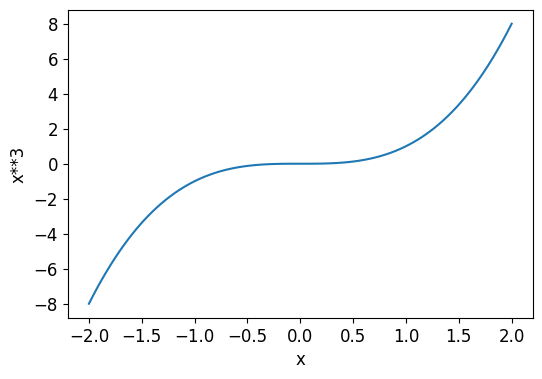

In [263]:
def f3(x): return x**3
plot_function(f3, 'x', 'x**3')

In [39]:
time = torch.arange(0, 20).float();time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

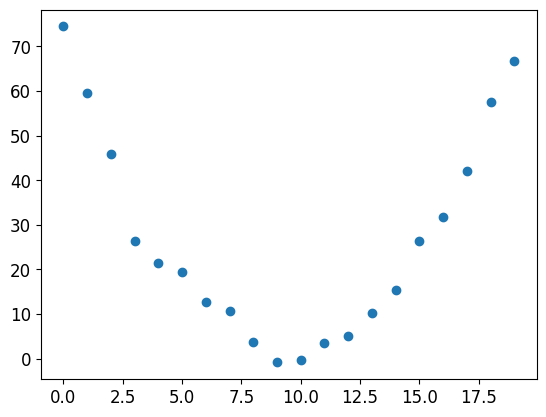

In [40]:
# it represents a speed measurements, they are not precise
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed);

Our goal is to approximate the function for finding speed

In [41]:

# let's go through 7 steps create a  find best 
# params for our spee function

########
## step 1 - initialise weights
########

params = torch.randn(3).requires_grad_()

In [42]:
# original params
orig_params = params.clone()
orig_params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward0>)

In [43]:
help(to_np)

Help on function to_np in module fastai.torch_core:

to_np(x)
    Convert a tensor to a numpy array.



In [44]:
def f(t, params):
    """
    We've assumed that function is quadratic,
    and goal is to find a best set of parameters
    """
    a,b,c = params
    return a*(t**2) + b*t + c

def show_preds(preds, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

def apply_step(params, prn: bool = True, lr=1e-5):
    # 1. calculate preds
    preds = f(time, params)
    # 2. calculate loss
    loss = mse(preds, speed)
    # 3. calculate gradient
    loss.backward()
    # 4. update params
    params.data -= lr*params.grad.data
    params.grad = None
    if prn:
        print(f'Loss: {loss.item()}')
    return preds

def init_params(size, std=1.0) -> tensor: 
    weights = torch.randn(size) * std
    weights.requires_grad_()
    return weights
    

def linear1(x, weights, bias): return x @ weights + bias

In [45]:
########
## step 2 - make predictions
########
preds = f(time, params)

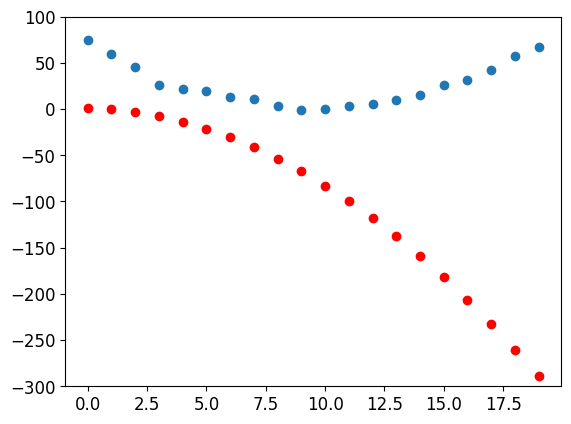

In [46]:
show_preds(preds) # Fig 3

Fig 3 shows pair graph, where blue is target, and red is result for randomly selected params. We'll try to improve

In [47]:
########
## step 3 - calculate how good is prediction
########
loss = mse(preds, speed); loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

```python
w -= gradient(w) * lr
```

This allows us to adjust the parameter **in the direction** of the slope by
- **increasing** the parameter when the slope is **negative** 
- **decreasing** the parameter when the slope is **positive**.

We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss

In [48]:
########
## step 4 - calculate gradient
########
# тут ми дивимось як параметри впливають на втрати
# наша ціль мнімізувати втрати
# для цього ми рахуємо градієнт (похідну) для функції втрат 
# для кожного параметра
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [49]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [50]:
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [51]:
orig_params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward0>)

In [52]:
params.data, params.grad.data

(tensor([-0.7658, -0.7506,  1.3525]),
 tensor([-53195.8633,  -3419.7148,   -253.8908]))

In [53]:
########
## Step 5 - Step (update) weights
########
lr = 1e-5
params.data -= params.grad.data * lr

# we need to zero-out grads, before proceeding to the new step
params.grad = None

In [54]:
params.data, orig_params.data

(tensor([-0.2339, -0.7164,  1.3551]), tensor([-0.7658, -0.7506,  1.3525]))

In [55]:
########
## 6. Go back and repeat step 2
########
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

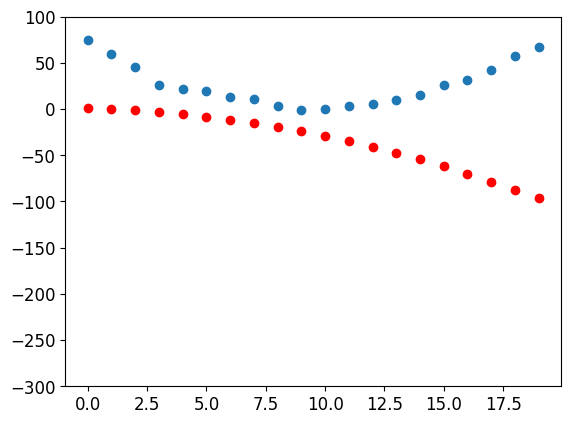

In [56]:
show_preds(preds)

In [57]:
####
## 7. Iterate until you decide to stop the training process.
####

for i in range(10): apply_step(params)

Loss: 5435.53564453125
Loss: 1577.44921875
Loss: 847.3778076171875
Loss: 709.2225341796875
Loss: 683.0758056640625
Loss: 678.1243896484375
Loss: 677.1838989257812
Loss: 677.0023193359375
Loss: 676.9645385742188
Loss: 676.9537353515625


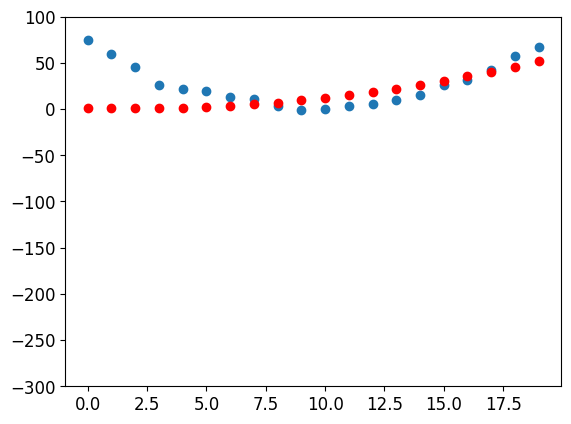

In [58]:
preds = f(time, params)
show_preds(preds)

In [59]:
params = torch.randn(3).requires_grad_()

Loss: 8631.7373046875
Loss: 2190.27587890625
Loss: 971.3508911132812
Loss: 740.6900634765625


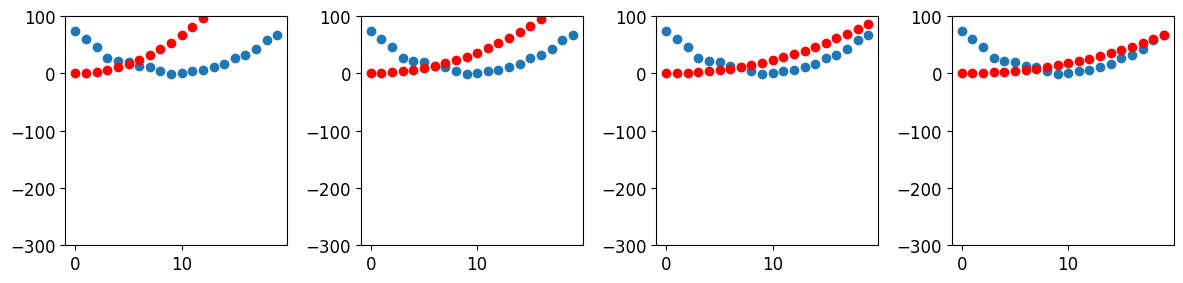

In [60]:
_, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params), ax)
plt.tight_layout()

Loss: 697.038818359375
Loss: 907.0774536132812
Loss: 5449.32373046875
Loss: 103662.1875


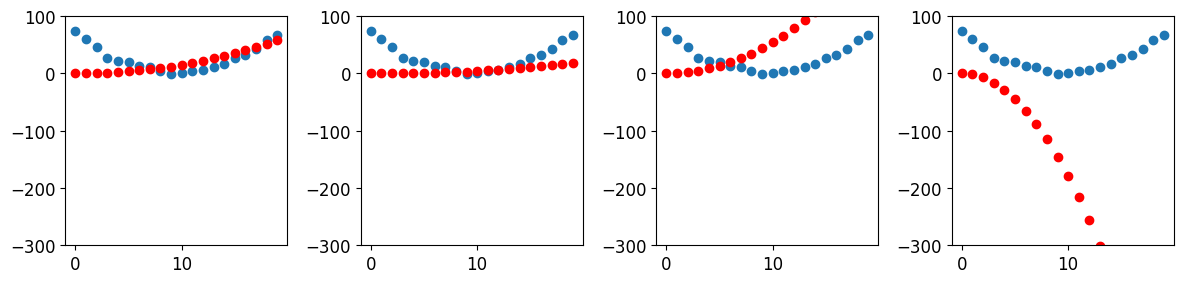

In [61]:
_, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, lr=1e-4), ax)
plt.tight_layout()

In [62]:
from fastbook import gv

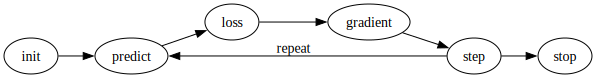

In [63]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [64]:
help(params.view)

Help on built-in function view:

view(...) method of torch.Tensor instance
    view(*shape) -> Tensor
    
    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different :attr:`shape`.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = d, \dots, d+k-1`,
    
    .. math::
    
      \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]
    
    Otherwise, it will not be possible to view :attr:`self` tensor as :attr:`shape`
    without copying it (e.g., via :meth:`contiguous`). When it is unclear whether a
    :meth:`view` can be performe

#### The MNIST Loss Function

In [65]:
seven_tensors[0].size(), len(seven_tensors)

(torch.Size([28, 28]), 6265)

In [70]:
# train dataset consists of examples of 7s and 3s
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.size()

torch.Size([12396, 784])

In [71]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [68]:
# label things
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [69]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [72]:
dataset = list(zip(train_x, train_y))
x,y = dataset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [73]:
valid_3_tensors.shape, valid_7_tensors.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [74]:

valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 28*28)
valid_x.shape

torch.Size([12396, 784])

In [75]:
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [76]:
dataset_valid = list(zip(valid_x, valid_y))
x,y = dataset_valid[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [77]:
weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [78]:
bias = init_params(1)

In [79]:
weights.T.shape

torch.Size([1, 784])

In [80]:
train_x[0].shape, weights.shape, bias.shape

(torch.Size([784]), torch.Size([784, 1]), torch.Size([1]))

In [81]:
# let's calculate a prediction for single image
(train_x[0] * weights.T).sum() + bias

tensor([8.4957], grad_fn=<AddBackward0>)

In [82]:
preds = linear1(train_x, weights, bias)

In [83]:
corrects = (preds > 0.0).float() == train_y

In [84]:
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [ True]])

In [85]:
corrects.float().mean().item()

0.5440464615821838

Поглянемо як зміна одного елементи з матриці ваг змінює точність
так як ми відслідковуємо зміни в параметрах `weights.requires_grad_()`
необхідно це вимкнути на час нашого тимчасового експерименту

In [86]:
with torch.no_grad(): weights[0] *= 1.0001

In [89]:
preds = linear1(train_x, weights, bias)
((preds > 0.5).float() == train_y).float().mean().item()

0.546789288520813

метрика точність, є поганим мірилом для функції втрат, так як її похідна або константа або прямує до нескінченності при значенні 0.5
тому нам потрібна функція котра даватиме більші значення - коли ми більше помиляємось, і відповідно нижчі значення, коли перебачення кращі.


In [90]:
def mnist(preds, targets):
    """
    Визначає дистанцію між передбаченнями та та правдивими значеннями
    """
    return torch.where(targets==1, 1 - preds, preds).mean()

In [95]:
targets = tensor([1, 0, 1])
preds = tensor([0.9, 0.1, 0.9])
mnist(preds, targets)

tensor(0.1000)

### Sigmoid

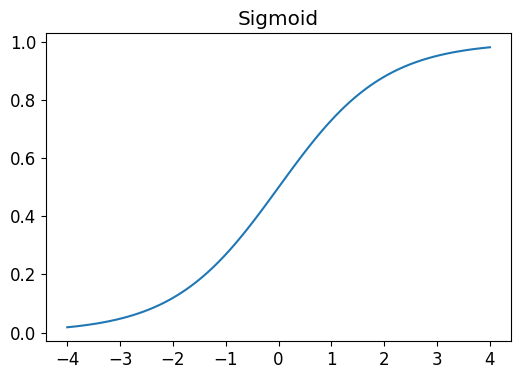

In [97]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [98]:
preds.sigmoid()

tensor([0.7109, 0.5250, 0.7109])

In [99]:
def mnist_sigmoid(preds, targets):
    predictions = preds.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions)

In [100]:
mnist_sigmoid(preds, targets)

tensor([0.2891, 0.5250, 0.2891])

### Stohastic Gradient Descend (SGD) and mini batches

Разхування функції фтрат для кожного елементу набору даних є довгим, з іншої сторони разування втрат для одного елементу є неточним та нерепрезентативним.
Вихід з такої ситуації є рахування втрат для випадкового набора даних (батч), розмір якого вибирається. Такий підхід волдодіє рисою, що прии з більшені батча точність збільшується, але і зростає час.

In [101]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)

list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

Сутність що слкдаєтья з кортежів де незалежні змінні обєднанні з залежною (true label)  називається набором даних - DataSet

In [105]:
ds = L(enumerate(string.ascii_lowercase))
print(len(ds))

26


In [107]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),
 (tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),
 (tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),
 (tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),
 (tensor([25, 21]), ('z', 'v'))]

In [ ]:
# pseudo code

for x, y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= loss.grad * lr

In [125]:
# ініціалізуємо на ші параметри
weights = init_params((28*28, 1))
bias = init_params(1)

weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

NameError: name 'dset' is not defined

In [113]:
dl = DataLoader(dataset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [118]:
valid_dl = DataLoader(dataset_valid, batch_size=256)

In [119]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [126]:
preds = linear1(batch, weights, bias)
preds

tensor([[ 5.6597],
        [ 7.5947],
        [13.4659],
        [12.5354]], grad_fn=<AddBackward0>)

In [127]:
loss = mnist(preds, train_y[:4])
loss

tensor(-8.8139, grad_fn=<MeanBackward0>)

In [128]:
# рахуєм градієнти/значення похідної
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad


(torch.Size([784, 1]), tensor(-0.1511), tensor([-1.]))

In [129]:
def calc_grad(X, y, model):
    preds = model(X)
    # рахуєм градієнти/значення похідної
    loss = mnist(preds, y)
    loss.backward()


In [130]:
calc_grad(batch, y, partial(linear1, weights=weights, bias=bias))
weights.grad.mean(), bias.grad

(tensor(-0.3022), tensor([-2.]))

In [131]:
calc_grad(batch, y, partial(linear1, weights=weights, bias=bias))
weights.grad.mean(), bias.grad

(tensor(-0.4534), tensor([-3.]))

In [147]:
def train_epoch(model, lr, params):
    global xb, yb, dl
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

def train_epoch_model(model, lr, params):
    global xb, yb, dl
    for xb,yb in dl:
        model(xb)
        model.forward()

In [135]:
(preds > 0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [136]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    corrects = (preds > 0.5) == yb
    return corrects.float().mean()

In [137]:
batch_accuracy(linear1(batch, weights, bias), train_y[:4])

tensor(1.)

In [145]:
def validate_epoch(model, valid_dl):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accuracies).mean().item(), 4)

In [140]:
model = partial(linear1, weights=weights, bias=bias)
validate_epoch(model, valid_dl)

0.7595

In [155]:
# тренуєм одну епоху
lr = 1

params = weights, bias
train_epoch(model, lr, params)
validate_epoch(model, valid_dl)

0.9503

In [161]:
weights = init_params((28*28, 1))
bias = init_params(1)
params = weights, bias
model = partial(linear1, weights=weights, bias=bias)

for i in range(20): # кількість епох
    train_epoch(model, lr, params)
    print(f'{validate_epoch(model, valid_dl)}', end=' ')

0.9609 0.9613 0.9617 0.9617 0.9616 0.9615 0.9616 0.9616 0.9616 0.9616 0.9616 0.9616 0.9616 0.9616 0.9617 0.9617 0.9616 0.9617 0.9617 0.9617 

### Створення оптимізтора

In [166]:
linear_model = nn.Linear(28*28, 1)
weights, bias = linear_model.parameters()

params = weights, bias

for i in range(20): # кількість епох

    train_epoch(linear_model, 1e-4, params)
    print(f'{validate_epoch(linear_model, valid_dl)}', end=' ')


0.5335 0.6206 0.6995 0.7664 0.8168 0.856 0.8809 0.8998 0.9109 0.92 0.9274 0.9326 0.9353 0.9382 0.941 0.9435 0.9451 0.9466 0.9475 0.9483 

In [167]:
# наша мета стоврити оптимізатор
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs): 
        for p in self.params: p.data -= self.lr * p.grad.data
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
    

In [169]:
opt = BasicOptim(linear_model.parameters(), lr)

In [180]:
# спрощена рутина тренування
def train_epoch(model, dl, opt: BasicOptim = None):

    for xb, xy in dl:
        calc_grad(xb, xy, model)
        opt.step()
        opt.zero_grad()


In [172]:
validate_epoch(linear_model, valid_dl)

0.9483

In [188]:
def train_model(model,  train_dataloader: DataLoader, valid_dataloader: DataLoader, num_epochs: int,opt = None,  lr=1e-4):
    opt = opt or  BasicOptim(model.parameters(), lr)
    for i in range(num_epochs):
        train_epoch(model, train_dataloader, opt)
        print(f'Num of epoch: {i}, validation loss: {validate_epoch(model, valid_dataloader)}')

In [193]:
linear_model = nn.Linear(28*28, 1)

train_model(linear_model, dl, valid_dl, 10)

Num of epoch: 0, validation loss: 0.5225
Num of epoch: 1, validation loss: 0.5735
Num of epoch: 2, validation loss: 0.629
Num of epoch: 3, validation loss: 0.6818
Num of epoch: 4, validation loss: 0.7297
Num of epoch: 5, validation loss: 0.7713
Num of epoch: 6, validation loss: 0.8022
Num of epoch: 7, validation loss: 0.8235
Num of epoch: 8, validation loss: 0.843
Num of epoch: 9, validation loss: 0.8574


In [185]:
linear_model.parameters()

<bound method Module.parameters of Linear(in_features=784, out_features=1, bias=True)>

In [190]:
lr

1

In [197]:
linear_model = nn.Linear(28*28, 1)
sgd = SGD(linear_model.parameters(), 1e-3)
train_model(linear_model, dl, valid_dl, 10, sgd)

Num of epoch: 0, validation loss: 0.902
Num of epoch: 1, validation loss: 0.9399
Num of epoch: 2, validation loss: 0.9506
Num of epoch: 3, validation loss: 0.9538
Num of epoch: 4, validation loss: 0.9559
Num of epoch: 5, validation loss: 0.9572
Num of epoch: 6, validation loss: 0.9579
Num of epoch: 7, validation loss: 0.9587
Num of epoch: 8, validation loss: 0.9595
Num of epoch: 9, validation loss: 0.9599


In [198]:
dls = DataLoaders(dl, valid_dl)
dls

In [200]:
help(SGD)

Help on function SGD in module fastai.optimizer:

SGD(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.0, wd: 'Real' = 0.0, decouple_wd: 'bool' = True) -> 'Optimizer'
    A SGD `Optimizer`



In [221]:
learner = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist, metrics=batch_accuracy)

In [225]:
learner.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,batch_accuracy,time
0,-9.067236,-9.871964,0.960471,00:00
1,-9.293612,-10.203570,0.960471,00:00
2,-9.555001,-10.535175,0.960471,00:00
3,-9.839257,-10.866780,0.960552,00:00
4,-10.136688,-11.198388,0.960552,00:00
5,-10.441020,-11.529995,0.960552,00:00
6,-10.748726,-11.861602,0.960713,00:00
7,-11.057994,-12.193209,0.960794,00:00
8,-11.367962,-12.524816,0.960794,00:00
9,-11.678231,-12.856424,0.960794,00:00


#### Додавання нелінійності.
Додавання нелінійності дає змогу вирішувати широкий спектр задач, бо бгато явищ, процесів в реальному житті нелінійні.
якщо наша функція(модель), достатньо "розвинута" то це дає нам можливість наближено рахувати/моделювати такі процеси.
Щоб переламати лінію ми використовуєм ReLU, це функція, що повертає 0 в разі вхідне значення негативне, інакше оригінальне значення:
`ReLU = max(x, 0)`

In [ ]:
# пскевдокод
def simple_net(xb):
    """
    Ідея проста, послідовно перемножити вхідні дані на набір різних ваг та баясів
    """
    res = xb@w1 + b1
    # застосовуєм ReLU
    res = res.max(tensor(0))
    res = res@w2 + b2
    return res

In [256]:
# перепишем simple_net використовуючи nn.Sequential()
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
learner = Learner(dls, simple_net, loss_func=mnist, opt_func=SGD, metrics=batch_accuracy)
learner.fit(50, 1e-4)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.337233,0.463798,0.724185,00:00
1,0.333949,0.458928,0.749355,00:00
2,0.330155,0.454023,0.770571,00:00
3,0.326020,0.449074,0.792110,00:00
4,0.321679,0.444071,0.810261,00:00
5,0.317214,0.439006,0.829380,00:00
6,0.312666,0.433872,0.841965,00:00
7,0.308059,0.428666,0.857777,00:00
8,0.303400,0.423380,0.867941,00:00
9,0.298685,0.417996,0.876734,00:00


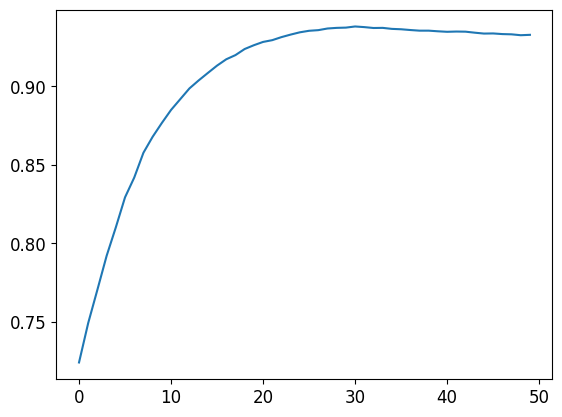

In [257]:
plt.plot(L(learner.recorder.values).itemgot(2))

In [259]:
learner.recorder.values[-1][2]

0.9328815937042236